# How bagging lowers model variance

## Imports and Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
from numpy.random import choice, normal
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

In [3]:
sns.set_style('white')
np.random.seed(seed=42)

In [4]:
results_path = Path('results', 'random_forest')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Bagged Decision Trees

To apply bagging to decision trees, we create bootstrap samples from our training data by repeatedly sampling with replacement, then train one decision tree on each of these samples, and create an ensemble prediction by averaging over the predictions of the different trees.

Bagged decision trees are usually grown large, that is, have many levels and leaf nodes and are not pruned so that each tree has low bias but high variance. The effect of averaging their predictions then aims to reduce their variance. Bagging has been shown to substantially improve predictive performance by constructing ensembles that combine hundreds or even thousands of trees trained on bootstrap samples.

To illustrate the effect of bagging on the variance of a regression tree, we can use the `BaggingRegressor` meta-estimator provided by `sklearn`. It trains a user-defined base estimator based on parameters that specify the sampling strategy:

- `max_samples` and `max_features` control the size of the subsets drawn from the rows and the columns, respectively
- `bootstrap` and `bootstrap_features` determine whether each of these samples is drawn with or without replacement

## A wiggly function to learn

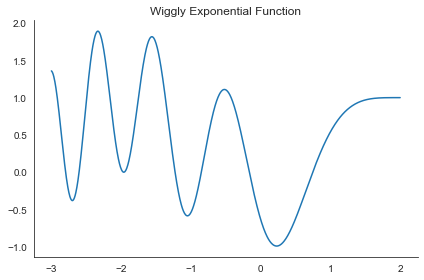

In [5]:
def f(x):
    return np.exp(-(x+2) ** 2) + np.cos((x-2)**2)

x = np.linspace(-3, 2, 1000)
y = pd.Series(f(x), index=x)
y.plot(title='Wiggly Exponential Function')
sns.despine()
plt.tight_layout();

## Simulate Training

The following example uses the preceding exponential function `f(x)` to generate training samples for a single DecisionTreeRegressor and a BaggingRegressor ensemble that consists of ten trees, each grown ten levels deep. Both models are trained on the random samples and predict outcomes for the actual function with added noise.

Since we know the true function, we can decompose the mean-squared error into bias, variance, and noise, and compare the relative size of these components for both models according to the following breakdown:

For 100 repeated random training and test samples of 250 and 500 observations each, we find that the variance of the predictions of the individual decision tree is almost twice as high as that for the small ensemble of 10 bagged trees based on bootstrapped samples:

In [6]:
test_size = 500
train_size = 250
reps = 100

noise = .5  # noise relative to std(y)
noise = y.std() * noise

X_test = choice(x, size=test_size, replace=False)

max_depth = 10
n_estimators=10

tree = DecisionTreeRegressor(max_depth=max_depth)
bagged_tree = BaggingRegressor(base_estimator=tree, n_estimators=n_estimators)
learners = {'Decision Tree': tree, 'Bagging Regressor': bagged_tree}

predictions = {k: pd.DataFrame() for k, v in learners.items()}
for i in range(reps):
    X_train = choice(x, train_size)
    y_train = f(X_train) + normal(scale=noise, size=train_size)
    for label, learner in learners.items():
        learner.fit(X=X_train.reshape(-1, 1), y=y_train)
        preds = pd.DataFrame({i: learner.predict(X_test.reshape(-1, 1))}, index=X_test)
        predictions[label] = pd.concat([predictions[label], preds], axis=1)

In [7]:
# y only observed with noise
y_true = pd.Series(f(X_test), index=X_test)
y_test = pd.DataFrame(y_true.values.reshape(-1,1) + normal(scale=noise, size=(test_size, reps)), index=X_test)

In [8]:
result = pd.DataFrame()
for label, preds in predictions.items():
    result[(label, 'error')] = preds.sub(y_test, axis=0).pow(2).mean(1)    # mean squared error
    result[(label, 'bias')] = y_true.sub(preds.mean(axis=1), axis=0).pow(2)             # bias
    result[(label, 'variance')] = preds.var(axis=1)
    result[(label, 'noise', )] = y_test.var(axis=1)
result.columns = pd.MultiIndex.from_tuples(result.columns)

In [9]:
df = result.mean().sort_index().loc['Decision Tree']
f"{(df.error- df.drop('error').sum()) / df.error:.2%}"

'0.29%'

In [10]:
df = result.mean().sort_index().loc['Bagging Regressor']
f"{(df.error- df.drop('error').sum()) / df.error:.2%}"

'0.25%'

### Visualize Bias-Variance Breakdown

For each model, the following plot shows the mean prediction and a band of two standard deviations around the mean for both models in the upper panel, and the bias-variance-noise breakdown based on the values for the true function in the bottom panel:

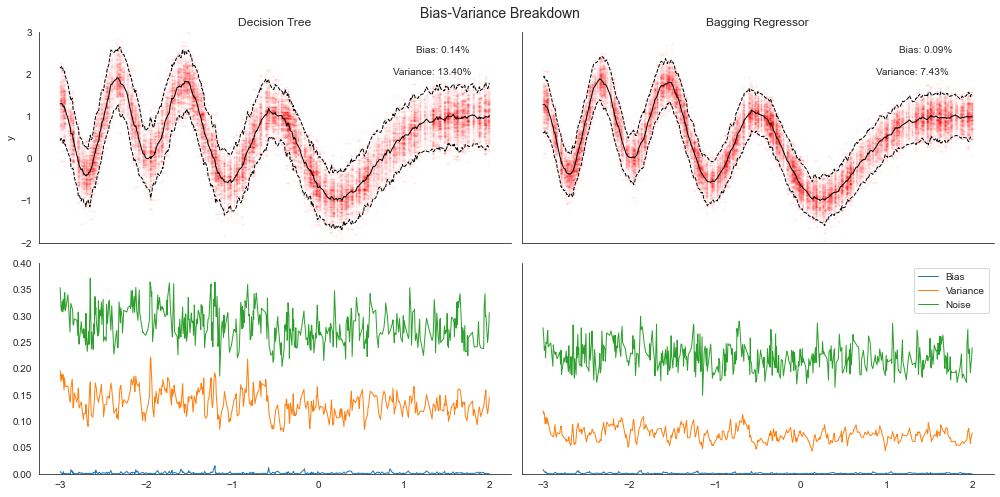

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(14, 7), sharex=True, sharey='row')
axes = axes.flatten()
idx = pd.IndexSlice

for i, (model, data) in enumerate(predictions.items()):
    mean, std = data.mean(1), data.std(1).mul(2)
    (pd.DataFrame([mean.sub(std), mean, mean.add(std)]).T
     .sort_index()
     .plot(style=['k--', 'k-', 'k--'], ax=axes[i], lw=1, legend=False, ylim=(-2, 3)))
    (data.stack().reset_index()
     .rename(columns={'level_0': 'x', 0: 'y'})
     .plot.scatter(x='x', y='y', ax=axes[i], alpha=.02, s=2, color='r', title=model))
    r = result[model]
    m = r.mean()
    kwargs = {'transform': axes[i].transAxes, 'fontsize':10}
    axes[i].text(x=.8, y=.9, s=f'Bias: {m.bias:.2%}', **kwargs)
    axes[i].text(x=.75, y=.8, s=f'Variance: {m.variance:.2%}', **kwargs)
    
    (r.drop('error', axis=1).sort_index()
     .rename(columns=str.capitalize)
     .plot(ax=axes[i+2], lw=1, legend=False, stacked=True, ylim=(0, .4)))

axes[-1].legend(fontsize=10)
fig.suptitle('Bias-Variance Breakdown', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.93);